In [1665]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import math
from numpy import diff
from tqdm import tqdm
from scipy import interpolate
from scipy.interpolate import interp1d
from pycbc.types import TimeSeries, FrequencySeries
from lal import MSUN_SI, MTSUN_SI, G_SI, PC_SI, C_SI
import scipy.optimize
import lal
from pycbc import waveform, types
from pycbc.waveform import get_td_waveform
from pycbc.types import TimeSeries, FrequencySeries
from lal import MSUN_SI, MTSUN_SI, G_SI, PC_SI, C_SI
import scipy.optimize

In [1666]:
### Calling NR waveforms (SXS simulations used)

(array([  798,   799,   800, ..., 16930, 16931, 16932]),)
16135
time: 3423.064236843078 
 index: 14523 
 length: 16135


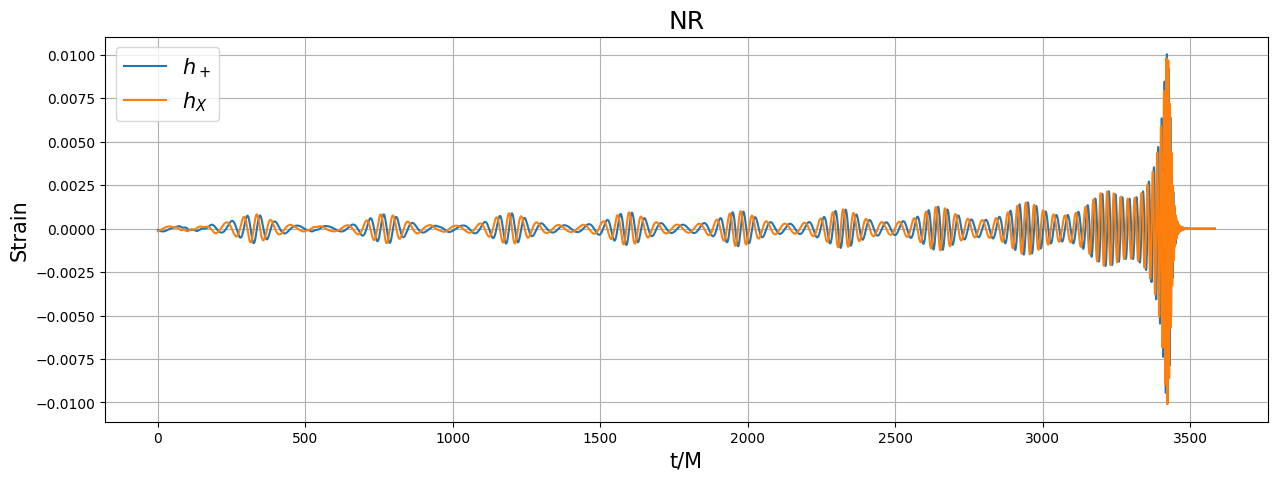

In [1667]:
#modify filename to include directory path to file, 
#for e.g. '/home/SXSfiles/1365_rhOverM_Asymptotic_GeometricUnits_CoM.h5' 
simulation = '1374_rhOverM_Asymptotic_GeometricUnits_CoM.h5'  
tref = 320.0 #tref is the start time of usable SXS waveforms, check metadata of simulation to obtain it
sims = simulation.split('_')[0]
lp = 5 # change accordingly
mp = 5
mode = 'l'+str(lp)+'_m'+str(mp)
with h5py.File('/home/pratul/Downloads/Project/NR_data/'+simulation, 'r') as hdf:     
    temp=hdf['OutermostExtraction.dir']['Y_'+mode+'.dat']
    test=np.array(temp)
        
x1=test[:,0]
y1=test[:,1]    
z1=test[:,2]

plotband=np.where(x1>=tref)
print(plotband)

x1=x1[plotband]
x1=x1-x1[0]
y1=y1[plotband]    
z1=z1[plotband]
print(len(x1))

tot=y1-1j*z1
amp=abs(tot)
ph=np.angle(tot)
phase_NR=np.unwrap(ph)
w=np.absolute(diff(phase_NR)/diff(x1))
phi0=phase_NR[0]


plt.figure(figsize=(15,5))
plt.plot(x1,y1,label='$h_+$')
plt.plot(x1,z1,label='$h_X$')
plt.title("NR",fontsize=18)
plt.ylabel("Strain", fontsize=15)
plt.xlabel("t/M", fontsize=15)
plt.grid()
plt.legend(loc=2,prop={'size': 15})

print('time:',x1[np.argmax(amp)],'\n index:',np.argmax(amp),'\n length:',len(amp))

### Parameters for generating inspiral waveform

In [1668]:
# Window:  time_NR[0] to -1000M:
# M = 30M_Sun
# q = 2
# e = 0.1217557644932139
# f = 20.000932607017745
# NR simulation : SXS:BBH:1364

# Window:  -2000M to -1000M:
# M = 30M_Sun
# q = 2
# e = 0.1208977180370708
# f = 19.999214896912523
# NR simulation : SXS:BBH:1364

In [1669]:
# initial frequency from table
total_mass = 30
freq = 10.62
xl = (total_mass*MTSUN_SI*math.pi*freq)**(2/3)

In [1670]:
print(xl)

0.028966550775159947


In [1671]:
#these parameters have been obtained from Hinder et.al. 2019
q=3
eref=0.18
cl=lref=-0.265
e0=0.495 #initial eccentricity at xlow, will change if xlow changes
eta=neu=nu=q/(1+q)**2 
xref=0.075 
xlow=xl # xlow is either xl or 0.045 #xlow can be chosen to be any value, we have chosen 0.045 to be the start of our hybrids
G=c=M=d=1
d0=1
M0=1
M2=M/(1+q)
M1=M2*q
modetopolfac=4*(5/(64*np.pi))**(1/2) # 22 mode factor

#lref = (lref + np.pi) % (2 * np.pi) - np.pi  #use only for SXS:BBH:1167
#cl = lref

hl2m2pVec=y1
hl2m2cVec=z1
tVec=x1
M_SI=M*MSUN_SI
D_SI=(10**(6))*PC_SI
tVec_SI=tVec*M*MTSUN_SI;
hpVec_SI=hl2m2pVec*G_SI*M_SI/D_SI/C_SI/C_SI;
hcVec_SI=hl2m2cVec*G_SI*M_SI/D_SI/C_SI/C_SI;

2.7965111533110893e-06
16135 6312 3584.1655859525636


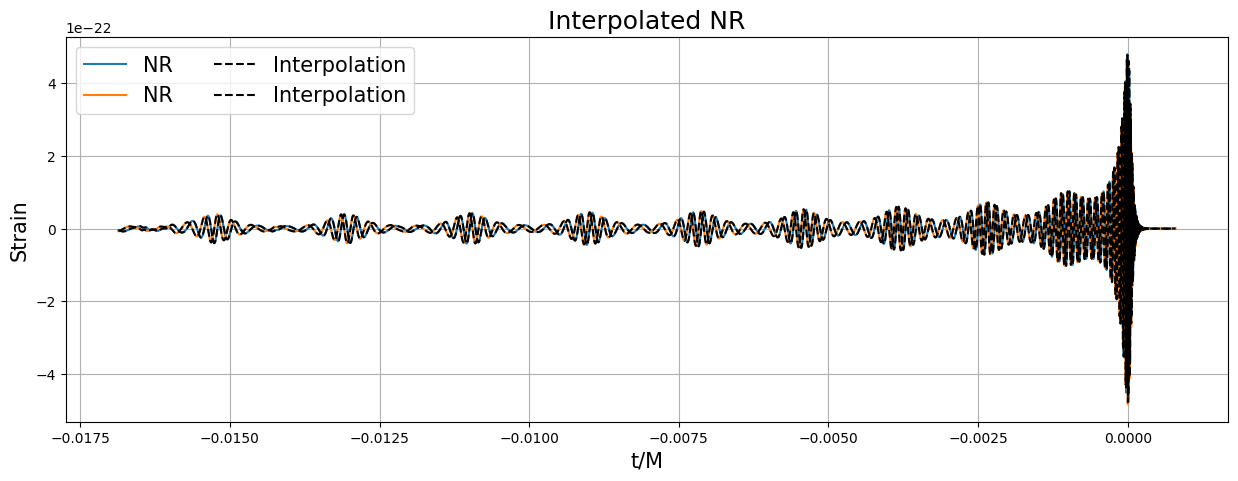

In [1672]:
delta_t_NR=np.max(abs(np.diff(tVec_SI)))   
print(delta_t_NR)

delta_t_common=delta_t_NR
t=tVec_SI

#### interpolation to sample data at equispaced time points
tVec_NR = np.linspace(t.min(),t.max(),int((t.max()-t.min())/delta_t_common)) 
hp_NR_sample = interp1d(t,hpVec_SI,kind='cubic')
hp_NR_int = hp_NR_sample(tVec_NR)
hc_NR_sample = interp1d(t,hcVec_SI,kind='cubic')
hc_NR_int = hc_NR_sample(tVec_NR)

#### converting to PyCBC TimeSeries
mergIdx_NR=np.argmax(np.abs(hp_NR_int+1j*hc_NR_int))
#hpVec_NR = TimeSeries(hp_NR_int,delta_t_common,epoch=0)
#hcVec_NR = TimeSeries(hc_NR_int,delta_t_common,epoch=0)

hpVec_NR = TimeSeries(hp_NR_int,delta_t_common,epoch=-tVec_NR[mergIdx_NR]) ## setting merger to t = 0 if needed
hcVec_NR = TimeSeries(hc_NR_int,delta_t_common,epoch=-tVec_NR[mergIdx_NR]) ## setting merger to t = 0 if needed

tVec_NR = tVec_NR - tVec_NR[mergIdx_NR] ## setting merger to t = 0 if needed

plt.figure(figsize=(15,5))
plt.plot(tVec_SI-tVec_SI[np.argmax(abs(hpVec_SI - 1j* hcVec_SI))],hpVec_SI,label='NR') 
plt.plot(tVec_SI-tVec_SI[np.argmax(abs(hpVec_SI - 1j* hcVec_SI))],hcVec_SI,label='NR') 

#plt.plot(tVec_SI,hpVec_SI,label='NR') 
#plt.plot(tVec_SI,hcVec_SI,label='NR') 
#plt.plot(hpVec_NR.sample_times,hpVec_NR,'k--',label='Interpolation')
plt.plot(tVec_NR,hp_NR_int,'k--',label='Interpolation')
plt.plot(tVec_NR,hc_NR_int,'k--',label='Interpolation')
plt.title("Interpolated NR",fontsize=18)
plt.ylabel("Strain", fontsize=15)
plt.xlabel("t/M", fontsize=15)
plt.grid()
plt.legend(loc=2,prop={'size': 15},ncol=2)
print(len(t),len(hpVec_NR),tVec[-1])

In [1673]:
phiC=phase_NR[mergIdx_NR]         
#tC_NR=hpVec_NR.sample_times[mergIdx_NR]
#phiC=phase_NR[len(hpVec_NR)]         
#tC_NR=max(hpVec_NR.sample_times)
tC_NR = hpVec_NR.sample_times[np.argmax(abs(hpVec_NR - 1j*hcVec_NR))]
Delta=math.sqrt(1-(4*neu))
eta=nu=neu
gamma=EulerGamma= 0.577215664901

%run GW_functions.ipynb
conv=M*MTSUN_SI               #total mass (needed to convert PN time t to t/M)

#Formula to compute f from a given x
def freq(i):
    return(i**(3/2)/(M*MTSUN_SI*math.pi))
 
f_low=freq(xlow)            #Lower frequency of EccTD wf which is in our hands
f_ref=freq(xref)            #Ref frequency of EccTD wf

####################################################

#Calculating ecc at xlow for generating EccTD wf-->eccentricity evolution Eq. (4.17a,b) Moore et. al.(2016)

x=xlow                         #x=point where eccentricity is required
v=math.sqrt(x)
vref=math.sqrt(xref)
xie=v**3
xiref=vref**3

#Gives e at xie with b.c.--> e=eref when xie=xiref

e=eref*(xiref/xie)**(19/18)*epsilon(xie, eta)/epsilon(xiref, eta) # this is using Moore evolution equation
#not using this eccentricity since we have used EccentricTD evolution to generate the initial eccentricity(e0) values

print(e) 
print(f_low)

0.9526097554909255
318.60000000000014


In [1674]:
print(tC_NR,hpVec_NR.sample_times[-1])

-4.769278994065651e-06 0.0007894398885462846


### Generating EccentricTD

In [1675]:
hpVec_PN, hcVec_PN = get_td_waveform(approximant='EccentricTD', mass1=M1, mass2=M2, 
                         delta_t=delta_t_common, 
                         f_lower=f_low, 
                         eccentricity=e0,
                         distance=d)

83424


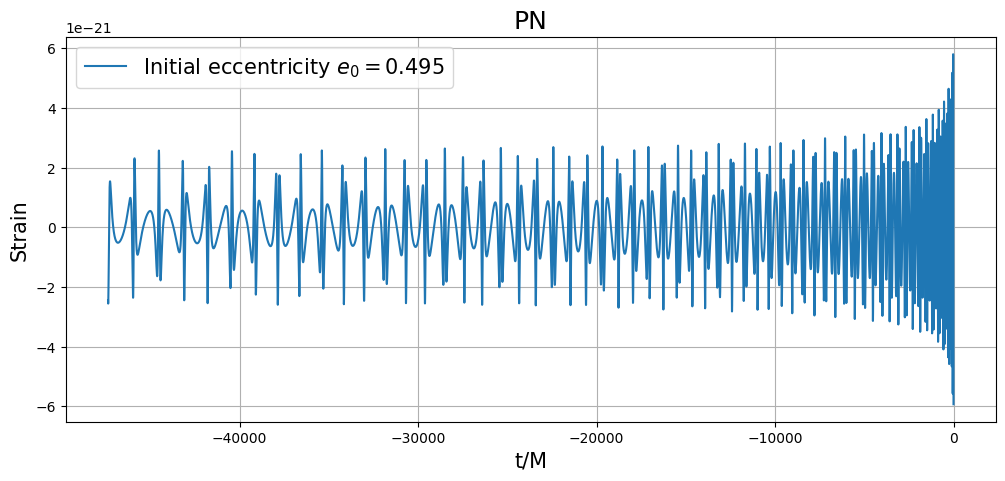

In [1676]:
plt.figure(figsize=(12,5))
tVec_PN_shifted=tC_NR+hpVec_PN.sample_times#-hpVec_PN.sample_times[-1]
plt.plot(tVec_PN_shifted/conv,hpVec_PN,label='Initial eccentricity $e_0=%1.3f$' %e0)
plt.title("PN",fontsize=18)
plt.ylabel("Strain", fontsize=15)
plt.xlabel("t/M", fontsize=15)
plt.grid()
plt.legend(loc=2,prop={'size': 15})
print(len(hpVec_PN))

In [1677]:
print(tVec_PN_shifted[-1])

-7.565336323067662e-06


In [1678]:
print(len(hpVec_PN))

83424


### obtaining EccentricTD phase

In [1679]:
phase_EccTD = waveform.utils.phase_from_polarizations(hpVec_PN/(modetopolfac*(G_SI*M_SI/D_SI/C_SI/C_SI)), hcVec_PN/(modetopolfac*(G_SI*M_SI/D_SI/C_SI/C_SI)))

In [1680]:
tVec_PN_GM=tVec_PN_shifted/conv
tVec_NR_GM=tVec_NR/conv
hpVec_PN_GM=np.array(hpVec_PN)/(modetopolfac*(G_SI*M_SI/D_SI/C_SI/C_SI))
hcVec_PN_GM=np.array(hcVec_PN)/(modetopolfac*(G_SI*M_SI/D_SI/C_SI/C_SI))

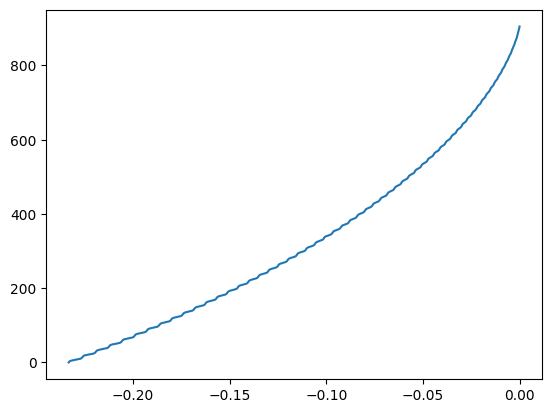

In [1681]:
plt.plot(hpVec_PN.sample_times,phase_EccTD)

In [1682]:
tC_NR=tC_NR/conv
tC_NR

-0.9682849830265022

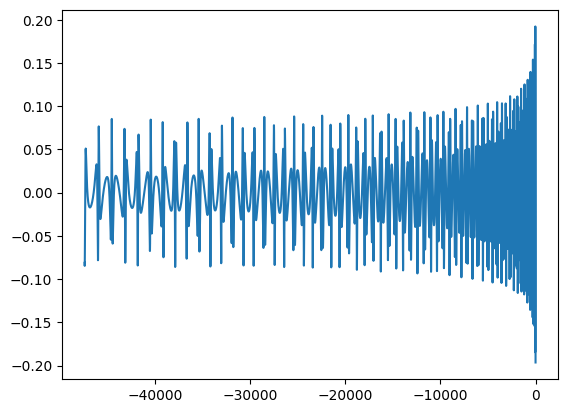

In [1683]:
plt.plot(tVec_PN_GM,hpVec_PN_GM)

In [1684]:
# use only if EccTD hybrids needed

#hlm_real = np.real(hpVec_PN_GM - 1j*hcVec_PN_GM)
#hlm_imag = np.imag(hpVec_PN_GM - 1j*hcVec_PN_GM)

### Obtaining parameters for generating Ebersold+ amplitudes

In [1685]:
tVec_PN=tVec_PN_GM
tC_NR=tC_NR

xi_ref=xref**(3/2)
v_ref=xi_ref**(1/3)
#input initial params
x0=xlow
xi0=x0**(3/2)
v0=xi0**(1/3)
#e0=(eref*(xi_ref/xi0)**(19/18))*(epsilon(xi0, eta)/epsilon(xi_ref, eta))
l0=mean_anomaly(xi_ref, xi0, lref, eta, e0)
theta=((5*M/(eta))**(1/8))*(tC_NR-tVec_PN)**(-1/8)
theta0=((5*M/(eta))**(1/8))*(tC_NR-tVec_PN[0])**(-1/8)
fVec=x_from_t(theta, theta0, e0, M, eta)

In [1686]:
print(tC_NR-tVec_PN)

[4.73650535e+04 4.73644857e+04 4.73639180e+04 ... 1.70319661e+00
 1.13543370e+00 5.67670779e-01]


In [1687]:
xiVec=(np.pi*M*fVec)
#print('xiVec:', xiVec)
xVec=xiVec**(2/3)
print('xVec:', xVec)
vVec=xiVec**(1/3)

xVec: [0.02740996 0.02741015 0.02741034 ...        nan        nan        nan]


In [1688]:
#selct +ve frequencies
plotIdx2=np.nonzero(fVec>=0)
fVec=fVec[plotIdx2]
xiVec=xiVec[plotIdx2]
xVec=xVec[plotIdx2]
vVec=vVec[plotIdx2]
maxPNidx=len(xVec)
print(maxPNidx)

83313


In [1689]:
len(xVec), len(phase_EccTD)

(83313, 83424)

### Ebersold+ amplitudes

In [1690]:
j=0
omega=[]
hlm_real=[]
hlm_imag=[]
hlm_abs=[]
for i in tqdm(xVec):
    v=math.sqrt(i)
    v0=math.sqrt(x0)
    xie=v**3
    xi0=v0**3
    l=mean_anomaly(xie, xi0, l0, eta, e0)
    e=e0*(xi0/xie)**(19/18)*epsilon(xie, eta)/epsilon(xi0, eta)
    #psi=phase_TT2(v, v0, phiC, eta)+W(xie, xi0, eta, e0, l)
    psi=phase_EccTD[j]
    j=j+1
    xi=l   #use xi for amplitude (xie is being used for v**3)
    x=i
    
    #change according to the hlm required, check GW_functions.ipynb for the function definitions and arguements
    h=amplitude_55(xi,x,nu,Delta,e)
    hlm=8*math.sqrt(math.pi/5)*M*neu*i*h*((np.e)**(complex(0,-1)*mp*psi/2))/d
    hlm0 = hlm *M0/d0
    hlm_real.append(hlm0.real)
    hlm_imag.append(hlm0.imag)
    hlm_abs.append(abs(hlm0))
print((hlm_real))

100%|███████████████████████████████████| 83313/83313 [01:19<00:00, 1044.03it/s]

[-3.0111521068872844e-05, -1.9736458593876695e-05, -8.871693815495308e-06, 2.019104374417599e-06, 1.2465845955941208e-05, 2.201263679195707e-05, 3.023830270581242e-05, 3.6775951413663726e-05, 4.133072643851234e-05, 4.3694966429076785e-05, 4.3760076531863096e-05, 4.152454215157839e-05, 3.709766480153731e-05, 3.0698768796587315e-05, 2.265180947937781e-05, 1.3375501056161519e-05, 3.369267199595362e-06, -6.804507315757796e-06, -1.654128790115974e-05, -2.5217494505803428e-05, -3.22150250500054e-05, -3.694625402761944e-05, -3.887852970589411e-05, -3.755719961747387e-05, -3.262623914003489e-05, -2.3845640371444287e-05, -1.1104835029218747e-05, 5.568428746704392e-06, 2.600416577855543e-05, 4.989141242253165e-05, 7.678469029599826e-05, 0.00010611550247331122, 0.00013720849633908674, 0.00016930174804954322, 0.00020157046473127206, 0.0002331532684098553, 0.0002631801257928204, 0.00029080092339431595, 0.0003152136614403149, 0.00033569125260885673, 0.00035160596273798016, 0.0003624506178585549, 0.0

In [1691]:
mp, j

(5, 83313)

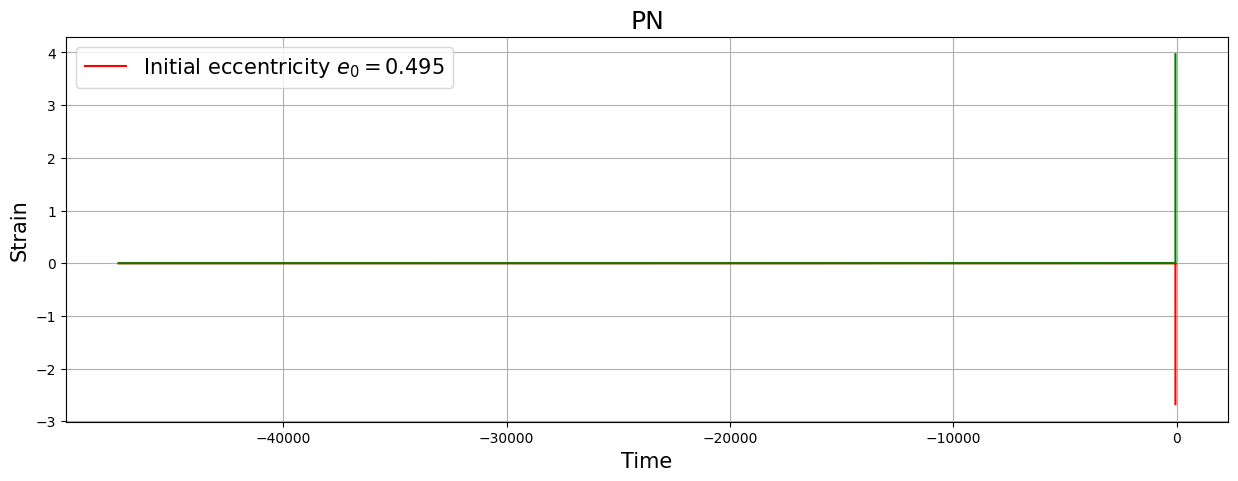

In [1692]:
plt.figure(figsize=(15,5))
#print(hlm_real[:])
plt.plot(tVec_PN_GM[:maxPNidx],hlm_real[:],'r',label='Initial eccentricity $e_0=%1.3f$' %e0)
plt.plot(tVec_PN_GM[:maxPNidx],hlm_abs[:],'g')
plt.title("PN", fontsize=18)
plt.ylabel("Strain", fontsize=15)
plt.xlabel("Time", fontsize=15)
#plt.xlim(xmin=-500)
#plt.xlim(xmax=2500)
#plt.ylim(-0.5e0,0.5e0)
plt.grid()
plt.legend(loc=2,prop={'size': 15})
#plt.savefig("4.png",dpi=300)

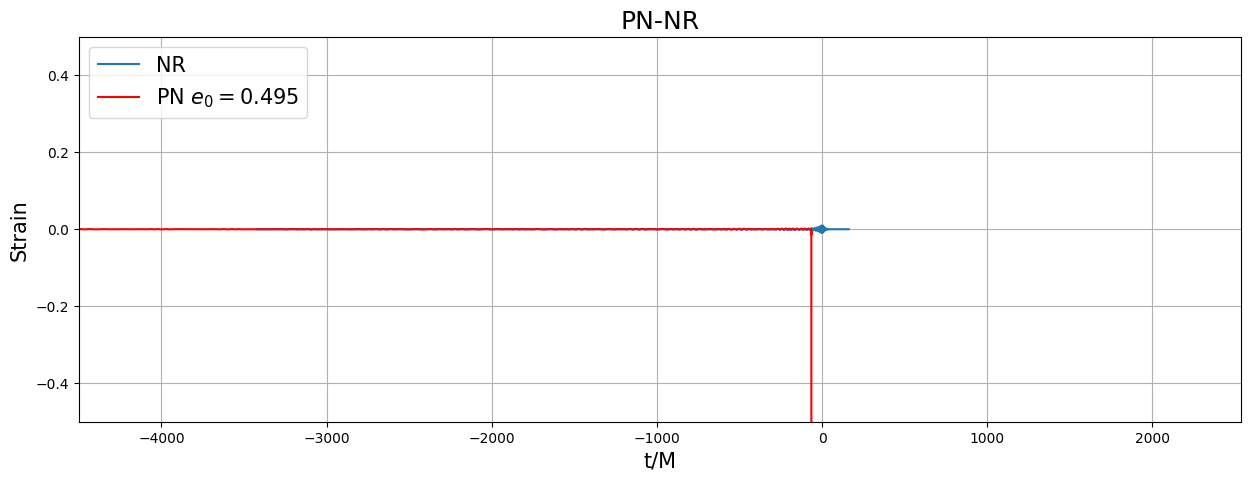

In [1693]:
plt.figure(figsize=(15,5))
plt.plot(tVec_NR_GM, hpVec_NR/(G_SI*M_SI/D_SI/C_SI/C_SI), label='NR')
plt.plot(tVec_PN_GM[:maxPNidx],hlm_real,'r',label='PN $e_0=%1.3f$' %e0) # Ebersold
#plt.plot(tVec_PN_GM[:],hlm_real,'r',label='PN $e_0=%1.3f$' %e0) # EccTD
#plt.plot(tVec_PN_GM[:maxPNidx],hlm_imag,'r',label='PN $e_0=%1.3f$' %e0) 
plt.ylim(ymax=0.5)
plt.ylim(ymin=-0.5)
plt.xlim(xmin=-4500)
#plt.xlim(xmax=6700)
plt.title("PN-NR",fontsize=18)
plt.ylabel("Strain", fontsize=15)
plt.xlabel("t/M", fontsize=15)
plt.grid()
plt.legend(loc=2,prop={'size': 15})

### Hybridization routine

In [1694]:
## merger at zero
t1Idx_NR=np.where(tVec_NR_GM>=-2000.0)[0][0]
t1Idx_PN=np.where(tVec_PN_GM>=-2000.0)[0][0]

t2Idx_NR=np.where(tVec_NR_GM>=-1000.0)[0][0]
t2Idx_PN=np.where(tVec_PN_GM>=-1000.0)[0][0]

##merger at t>0
t1Idx_NR=np.where(tVec_NR_GM>=1000)[0][0]
t1Idx_PN=np.where(tVec_PN_GM>=1000)[0][0]

t2Idx_NR=np.where(tVec_NR_GM>=2000.0)[0][0]
t2Idx_PN=np.where(tVec_PN_GM>=2000.0)[0][0]

In [1695]:
print(tVec_NR_GM[t1Idx_NR],tVec_PN_GM[t1Idx_PN])

-1999.6588540863536 -1999.49366139347


In [1696]:
stretch=abs(tVec_NR_GM[t1Idx_NR]-tVec_NR_GM[t2Idx_NR])
print('NR matching window in t/M:',stretch)
print('NR matching indices:',t1Idx_NR,'\t',t2Idx_NR)

stretch=abs(tVec_PN_GM[t1Idx_PN]-tVec_PN_GM[t2Idx_PN])
print('\nPN matching window in t/M:',stretch)
print('PN matching indices:',t1Idx_PN,'\t',t2Idx_PN)

NR matching window in t/M: 1000.1133888230811
NR matching indices: 2506 	 4267

PN matching window in t/M: 999.8304971913644
PN matching indices: 79904 	 81665


In [1697]:
print(t2Idx_NR - t1Idx_NR,t2Idx_PN-t1Idx_PN)

1761 1761


In [1698]:
hpVec_NR_GM=hp_NR_int/(G_SI*M_SI/D_SI/C_SI/C_SI)
hcVec_NR_GM=hc_NR_int/(G_SI*M_SI/D_SI/C_SI/C_SI)

In [1699]:
if (t2Idx_NR - t1Idx_NR)<(t2Idx_PN-t1Idx_PN):
    t2Idx_NR = t2Idx_NR+1

In [1700]:
hpVec_NR_crop=hpVec_NR_GM[t1Idx_NR:t2Idx_NR]
hcVec_NR_crop=hcVec_NR_GM[t1Idx_NR:t2Idx_NR]
tVec_NR_crop=tVec_NR_GM[t1Idx_NR:t2Idx_NR]

def PN_crop(pnshiftIdx):
    hpVec_PN_crop=np.array(hlm_real[t1Idx_PN+pnshiftIdx:t2Idx_PN+pnshiftIdx])
    #hpVec_PN_crop=np.array(hlm_imag[t1Idx_PN+pnshiftIdx:t2Idx_PN+pnshiftIdx])
    tVec_PN_crop=tVec_PN_GM[t1Idx_PN+pnshiftIdx:t2Idx_PN+pnshiftIdx]
    return(tVec_PN_crop, hpVec_PN_crop)

In [1701]:
def deltaPNNR(param_Vec, h_NR_crop, h_PN_crop):
    #return(np.sum(abs(h_NR_crop-param_Vec[2]*h_PN_crop*((np.e)**(1j*(param_Vec[0]+param_Vec[1]))))))
    #print(len(h_NR_crop))
    return(np.sum(abs(h_NR_crop-h_PN_crop[:len(h_NR_crop)]*((np.e)**(1j*(param_Vec[0]+param_Vec[1]))))))

In [1702]:
timeshiftIdxVec=np.arange(-500,500,1)

param_Vec_initial=[np.pi/2,0]
deltaVec=[]
paramVecmin=[]

for timeshiftIdx in timeshiftIdxVec:
    tVec_PN_crop, hpVec_PN_crop=PN_crop(timeshiftIdx)
    param_Vec_minimized = scipy.optimize.fmin(func=deltaPNNR, x0=param_Vec_initial, args=(hpVec_NR_crop,hpVec_PN_crop))
    deltaVec.append(deltaPNNR(param_Vec_minimized,hpVec_NR_crop,hpVec_PN_crop))
    paramVecmin.append(param_Vec_minimized)

Optimization terminated successfully.
         Current function value: 0.724153
         Iterations: 28
         Function evaluations: 53
Optimization terminated successfully.
         Current function value: 0.724226
         Iterations: 28
         Function evaluations: 53
Optimization terminated successfully.
         Current function value: 0.724586
         Iterations: 28
         Function evaluations: 53
Optimization terminated successfully.
         Current function value: 0.725321
         Iterations: 28
         Function evaluations: 53
Optimization terminated successfully.
         Current function value: 0.726568
         Iterations: 28
         Function evaluations: 53
Optimization terminated successfully.
         Current function value: 0.728150
         Iterations: 28
         Function evaluations: 53
Optimization terminated successfully.
         Current function value: 0.730247
         Iterations: 28
         Function evaluations: 53
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 0.737408
         Iterations: 28
         Function evaluations: 53
Optimization terminated successfully.
         Current function value: 0.736875
         Iterations: 28
         Function evaluations: 53
Optimization terminated successfully.
         Current function value: 0.736317
         Iterations: 28
         Function evaluations: 53
Optimization terminated successfully.
         Current function value: 0.735775
         Iterations: 28
         Function evaluations: 53
Optimization terminated successfully.
         Current function value: 0.735247
         Iterations: 28
         Function evaluations: 53
Optimization terminated successfully.
         Current function value: 0.734703
         Iterations: 28
         Function evaluations: 53
Optimization terminated successfully.
         Current function value: 0.734127
         Iterations: 28
         Function evaluations: 53
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 0.747689
         Iterations: 29
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: 0.768862
         Iterations: 30
         Function evaluations: 55
Optimization terminated successfully.
         Current function value: 0.765792
         Iterations: 30
         Function evaluations: 55
Optimization terminated successfully.
         Current function value: 0.762618
         Iterations: 28
         Function evaluations: 53
Optimization terminated successfully.
         Current function value: 0.759252
         Iterations: 28
         Function evaluations: 53
Optimization terminated successfully.
         Current function value: 0.755635
         Iterations: 28
         Function evaluations: 53
Optimization terminated successfully.
         Current function value: 0.751639
         Iterations: 28
         Function evaluations: 53
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 0.750886
         Iterations: 29
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: 0.761138
         Iterations: 29
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: 0.771122
         Iterations: 29
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: 0.780595
         Iterations: 29
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: 0.789430
         Iterations: 29
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: 0.797686
         Iterations: 29
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: 0.818126
         Iterations: 30
         Function evaluations: 55
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 0.734006
         Iterations: 28
         Function evaluations: 53
Optimization terminated successfully.
         Current function value: 0.728904
         Iterations: 28
         Function evaluations: 53
Optimization terminated successfully.
         Current function value: 0.724483
         Iterations: 28
         Function evaluations: 53
Optimization terminated successfully.
         Current function value: 0.720392
         Iterations: 28
         Function evaluations: 53
Optimization terminated successfully.
         Current function value: 0.716662
         Iterations: 28
         Function evaluations: 53
Optimization terminated successfully.
         Current function value: 0.712863
         Iterations: 28
         Function evaluations: 53
Optimization terminated successfully.
         Current function value: 0.709107
         Iterations: 28
         Function evaluations: 53
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 0.497209
         Iterations: 28
         Function evaluations: 53
Optimization terminated successfully.
         Current function value: 0.493755
         Iterations: 28
         Function evaluations: 53
Optimization terminated successfully.
         Current function value: 0.492290
         Iterations: 28
         Function evaluations: 53
Optimization terminated successfully.
         Current function value: 0.493179
         Iterations: 28
         Function evaluations: 53
Optimization terminated successfully.
         Current function value: 0.496999
         Iterations: 28
         Function evaluations: 53
Optimization terminated successfully.
         Current function value: 0.503319
         Iterations: 28
         Function evaluations: 53
Optimization terminated successfully.
         Current function value: 0.511644
         Iterations: 28
         Function evaluations: 53
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 0.743269
         Iterations: 29
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: 0.749753
         Iterations: 29
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: 0.756742
         Iterations: 29
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: 0.763791
         Iterations: 29
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: 0.771343
         Iterations: 29
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: 0.778632
         Iterations: 29
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: 0.785569
         Iterations: 29
         Function evaluations: 54
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 0.813390
         Iterations: 28
         Function evaluations: 53
Optimization terminated successfully.
         Current function value: 0.818682
         Iterations: 28
         Function evaluations: 53
Optimization terminated successfully.
         Current function value: 0.823986
         Iterations: 28
         Function evaluations: 53
Optimization terminated successfully.
         Current function value: 0.829269
         Iterations: 30
         Function evaluations: 55
Optimization terminated successfully.
         Current function value: 0.799883
         Iterations: 29
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: 0.793740
         Iterations: 29
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: 0.787880
         Iterations: 29
         Function evaluations: 54
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 0.804476
         Iterations: 28
         Function evaluations: 53
Optimization terminated successfully.
         Current function value: 0.807992
         Iterations: 30
         Function evaluations: 55
Optimization terminated successfully.
         Current function value: 0.811234
         Iterations: 30
         Function evaluations: 55
Optimization terminated successfully.
         Current function value: 0.792369
         Iterations: 29
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: 0.788712
         Iterations: 29
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: 0.785300
         Iterations: 29
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: 0.782268
         Iterations: 29
         Function evaluations: 54
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 0.806609
         Iterations: 30
         Function evaluations: 55
Optimization terminated successfully.
         Current function value: 0.805882
         Iterations: 30
         Function evaluations: 55
Optimization terminated successfully.
         Current function value: 0.804860
         Iterations: 28
         Function evaluations: 53
Optimization terminated successfully.
         Current function value: 0.803662
         Iterations: 28
         Function evaluations: 53
Optimization terminated successfully.
         Current function value: 0.802134
         Iterations: 28
         Function evaluations: 53
Optimization terminated successfully.
         Current function value: 0.800223
         Iterations: 28
         Function evaluations: 53
Optimization terminated successfully.
         Current function value: 0.798133
         Iterations: 28
         Function evaluations: 53
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 0.816546
         Iterations: 28
         Function evaluations: 53
Optimization terminated successfully.
         Current function value: 0.817071
         Iterations: 28
         Function evaluations: 53
Optimization terminated successfully.
         Current function value: 0.817518
         Iterations: 28
         Function evaluations: 53
Optimization terminated successfully.
         Current function value: 0.818164
         Iterations: 28
         Function evaluations: 53
Optimization terminated successfully.
         Current function value: 0.819457
         Iterations: 28
         Function evaluations: 53
Optimization terminated successfully.
         Current function value: 0.821346
         Iterations: 28
         Function evaluations: 53
Optimization terminated successfully.
         Current function value: 0.823835
         Iterations: 28
         Function evaluations: 53
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 0.842748
         Iterations: 28
         Function evaluations: 53
Optimization terminated successfully.
         Current function value: 0.851782
         Iterations: 30
         Function evaluations: 55
Optimization terminated successfully.
         Current function value: 0.840882
         Iterations: 29
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: 0.834060
         Iterations: 29
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: 0.828706
         Iterations: 29
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: 0.823851
         Iterations: 29
         Function evaluations: 54
Optimization terminated successfully.
         Current function value: 0.818957
         Iterations: 29
         Function evaluations: 54
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 0.865652
         Iterations: 28
         Function evaluations: 53
Optimization terminated successfully.
         Current function value: 0.856037
         Iterations: 28
         Function evaluations: 53
Optimization terminated successfully.
         Current function value: 0.846154
         Iterations: 28
         Function evaluations: 53
Optimization terminated successfully.
         Current function value: 0.836150
         Iterations: 28
         Function evaluations: 53


In [1703]:
minIdx=np.argmin(deltaVec)
phaseshift_min=paramVecmin[minIdx][0]
angularshift_min=paramVecmin[minIdx][1]
#ampshift_min=paramVecmin[minIdx][2]
timeshiftIdx_min=timeshiftIdxVec[minIdx]
minIdx, timeshiftIdx_min, phaseshift_min, angularshift_min #ampshift_min

(411, -89, 3.1403331115522395, 0.0012778224945068366)

In [1704]:
tau_new=tVec_PN_GM-(timeshiftIdx_min*delta_t_common/conv)
#tau_newc=tVec_PN_GM-(timeshiftIdx_minc*delta_t_common/conv)
hpVec_PN_phaseshifted=np.array(hlm_real)*(np.e)**(1j*phaseshift_min+angularshift_min)
hcVec_PN_phaseshifted=np.array(hlm_imag)*(np.e)**(1j*phaseshift_min+angularshift_min)

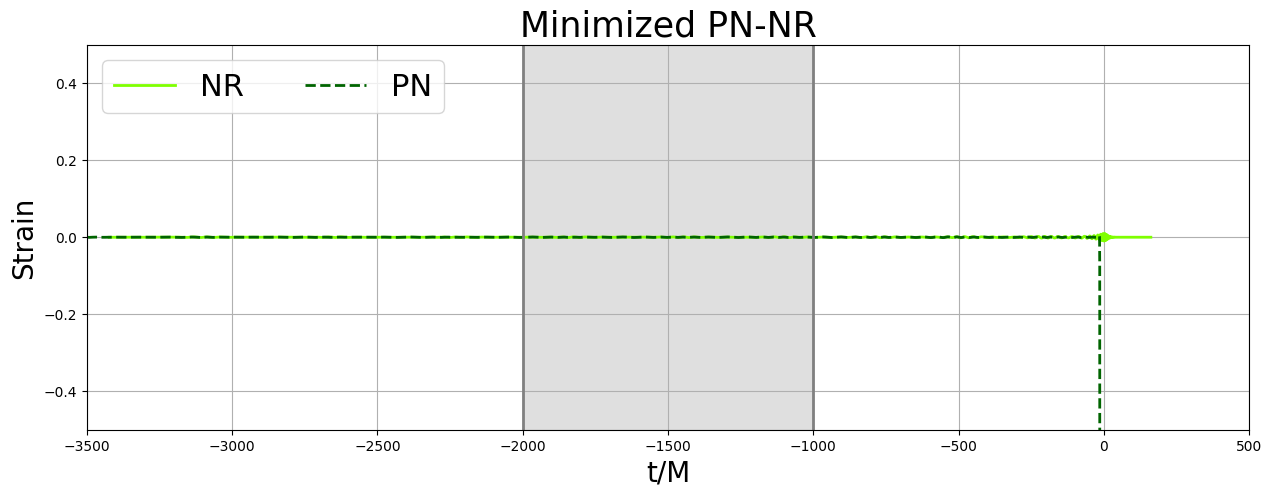

In [1705]:
plt.figure(figsize=(15,5))
##plt.plot(tVec_NR_GM,hp_NR_int/(G_SI*M_SI/D_SI/C_SI/C_SI),color='lightcoral',linewidth=2,label='NR')
##plt.plot(tau_new[:maxPNidx],hpVec_PN_phaseshifted[:],color='brown',linestyle='--',linewidth=2,label='PN')  ## for  EccTD+Ebersold hybrid
#plt.plot(tau_new[:],hpVec_PN_phaseshifted[:],color='brown',linestyle='--',linewidth=2,label='PN')  ## for full EccTD hybrid

plt.plot(tVec_NR_GM,hc_NR_int/(G_SI*M_SI/D_SI/C_SI/C_SI),color='chartreuse',linewidth=2,label='NR')
plt.plot(tau_new[:maxPNidx],hcVec_PN_phaseshifted[:],color='darkgreen',linestyle='--',linewidth=2,label='PN')  ## for  EccTD+Ebersold hybrid
#plt.plot(tau_new[:],hcVec_PN_phaseshifted[:],color='darkgreen',linestyle='--',linewidth=2,label='PN')  ## for full EccTD hybrid
#plt.title("Minimized PN-NR (EccTD+Ebersold)", fontsize=25)
plt.title("Minimized PN-NR", fontsize=25)
plt.ylabel("Strain", fontsize=20)
plt.xlabel("t/M", fontsize=20)

plt.axvline(x=tVec_NR_GM[int(t1Idx_NR)],linewidth=2, color='gray')
plt.axvline(x=tVec_NR_GM[int(t2Idx_NR)],linewidth=2, color='gray')
plt.axvspan(tVec_NR_GM[int(t1Idx_NR)], tVec_NR_GM[int(t2Idx_NR)],  alpha=0.5, color='silver')

plt.ylim(ymax=0.5)
plt.ylim(ymin=-0.5)
plt.xlim(xmin=-3500)
plt.xlim(xmax=500)
#plt.xticks(fontsize=20)
#plt.yticks(fontsize=20)
plt.legend(loc=2,prop={'size': 22},ncol=2)
plt.grid()
#plt.savefig('1364_tNRzero_to_neg1000_full_EccTD.png',dpi=600)
#plt.savefig('1372_EccTD_hybridization_new.png',dpi=600)

In [1706]:
hyb_time=[]
hyb_hp=[]
hyb_hc=[]

T1_PN=t1Idx_PN
T2_PN=t2Idx_PN

T1_NR=t1Idx_NR
T2_NR=t2Idx_NR

In [1707]:
for i in tau_new[:T1_PN+timeshiftIdx_min]:
    hyb_time.append(i)

for i in hpVec_PN_phaseshifted[:T1_PN+timeshiftIdx_min]:
    hyb_hp.append(i)
    
for i in hcVec_PN_phaseshifted[:T1_PN+timeshiftIdx_min]:
    hyb_hc.append(i)

for i,j in tqdm(zip(range(T1_NR,T2_NR), range((T1_PN+timeshiftIdx_min),(T2_PN+timeshiftIdx_min)))):
    tau=float((tVec_NR_GM[i]-tVec_NR_GM[int(T1_NR)])/(tVec_NR_GM[int(T2_NR)]-tVec_NR_GM[int(T1_NR)]))
    hpval=tau*hp_NR_int[i]/(modetopolfac*(G_SI*M_SI/D_SI/C_SI/C_SI))+(1-tau)*(hpVec_PN_phaseshifted[j])
    hcval=tau*hc_NR_int[i]/(modetopolfac*(G_SI*M_SI/D_SI/C_SI/C_SI))+(1-tau)*(hcVec_PN_phaseshifted[j])
    
    hyb_hp.append(hpval)
    hyb_hc.append(hcval)
    hyb_time.append(tVec_NR_GM[i])

In [1708]:
for i,j in tqdm(zip(range(T1_NR,T2_NR), range((T1_PN+timeshiftIdx_min),(T2_PN+timeshiftIdx_min)))):
    tau=float((tVec_NR_GM[i]-tVec_NR_GM[int(T1_NR)])/(tVec_NR_GM[int(T2_NR)]-tVec_NR_GM[int(T1_NR)]))
    hpval=tau*hp_NR_int[i]/((G_SI*M_SI/D_SI/C_SI/C_SI))+(1-tau)*(hpVec_PN_phaseshifted[j])
    hcval=tau*hc_NR_int[i]/((G_SI*M_SI/D_SI/C_SI/C_SI))+(1-tau)*(hcVec_PN_phaseshifted[j])
    
    hyb_hp.append(hpval)
    hyb_hc.append(hcval)
    hyb_time.append(tVec_NR_GM[i])

1761it [00:00, 64231.47it/s]


for i in tVec_NR_GM[T2_NR:]:
    hyb_time.append(i)
for i in hp_NR_int[T2_NR:]:
    hyb_hp.append(i/(modetopolfac*(G_SI*M_SI/D_SI/C_SI/C_SI)))
for i in hc_NR_int[T2_NR:]:
    hyb_hc.append(i/(modetopolfac*(G_SI*M_SI/D_SI/C_SI/C_SI)))

In [1709]:
for i in tVec_NR_GM[T2_NR:]:
    hyb_time.append(i)
for i in hp_NR_int[T2_NR:]:
    hyb_hp.append(i/((G_SI*M_SI/D_SI/C_SI/C_SI)))
for i in hc_NR_int[T2_NR:]:
    hyb_hc.append(i/((G_SI*M_SI/D_SI/C_SI/C_SI)))

plt.figure(figsize=(15,5))
plt.plot(hyb_time,np.real(hyb_hp))
plt.plot(hyb_time,np.real(hyb_hc))
plt.plot(hyb_time,np.abs(np.real(hyb_hp)+1j*np.real(hyb_hc)))
plt.plot(tVec_NR_GM,hp_NR_int/(modetopolfac*(G_SI*M_SI/D_SI/C_SI/C_SI)),'--')
plt.plot(tVec_NR_GM,hc_NR_int/(modetopolfac*(G_SI*M_SI/D_SI/C_SI/C_SI)),'--')
plt.plot(tVec_NR_GM,abs(hp_NR_int/(modetopolfac*(G_SI*M_SI/D_SI/C_SI/C_SI))+1j*hc_NR_int/(modetopolfac*(G_SI*M_SI/D_SI/C_SI/C_SI))),'--')
#plt.plot(hpVec_PN.sample_times/(MTSUN_SI)+3000,hpVec_PN/(modetopolfac*(G_SI*M_SI/D_SI/C_SI/C_SI)),'--')
plt.xlim(xmin=-1000)

(-3500.0, 500.0)

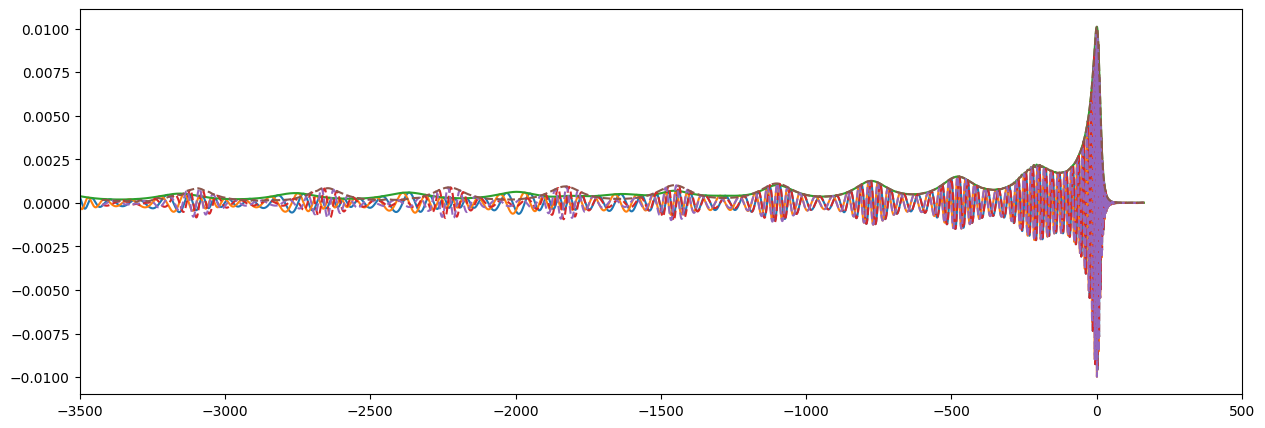

In [1710]:
plt.figure(figsize=(15,5))
plt.plot(hyb_time,np.real(hyb_hp))
plt.plot(hyb_time,np.real(hyb_hc))
plt.plot(hyb_time,np.abs(np.real(hyb_hp)+1j*np.real(hyb_hc)))
plt.plot(tVec_NR_GM,hp_NR_int/((G_SI*M_SI/D_SI/C_SI/C_SI)),'--')
plt.plot(tVec_NR_GM,hc_NR_int/((G_SI*M_SI/D_SI/C_SI/C_SI)),'--')
plt.plot(tVec_NR_GM,abs(hp_NR_int/((G_SI*M_SI/D_SI/C_SI/C_SI))+1j*hc_NR_int/((G_SI*M_SI/D_SI/C_SI/C_SI))),'--')
#plt.plot(hpVec_PN.sample_times/(MTSUN_SI)+3000,hpVec_PN/(modetopolfac*(G_SI*M_SI/D_SI/C_SI/C_SI)),'--')
plt.xlim(xmin=-3500)
plt.xlim(xmax=500)

### Saving hybrids to an HDF file

In [1711]:
print(len(hyb_hp),len(hyb_hc),len(hyb_time))

83621 83621 83621


In [1712]:
DataArray = np.transpose([hyb_time, np.real(hyb_hp), np.real(hyb_hc)])

In [1713]:
hf = h5py.File('/home/pratul/Downloads/Project/New hybrids/Ebersold/'+sims+'_EccTD_Ebersold_22_hyb.h5', 'a') ## change name of file to be created as required

In [1714]:
#hf.create_dataset('l2_m2', data=DataArray)
hf.create_dataset(mode, data=DataArray)

<HDF5 dataset "l5_m5": shape (83621, 3), type "<f8">

In [1715]:
hf.close()

### Checking the HDF file

In [1716]:
hf = h5py.File('/home/pratul/Downloads/Project/New hybrids/Ebersold/'+sims+'_EccTD_Ebersold_22_hyb.h5','r')

In [1717]:
print(hf.keys())

<KeysViewHDF5 ['l2_m1', 'l2_m2', 'l3_m2', 'l3_m3', 'l4_m3', 'l4_m4', 'l5_m5']>


In [1718]:
testd = hf.get(mode)

In [1719]:
print(len(testd[:,0]),testd[0,0])

83621 -47315.49089780948


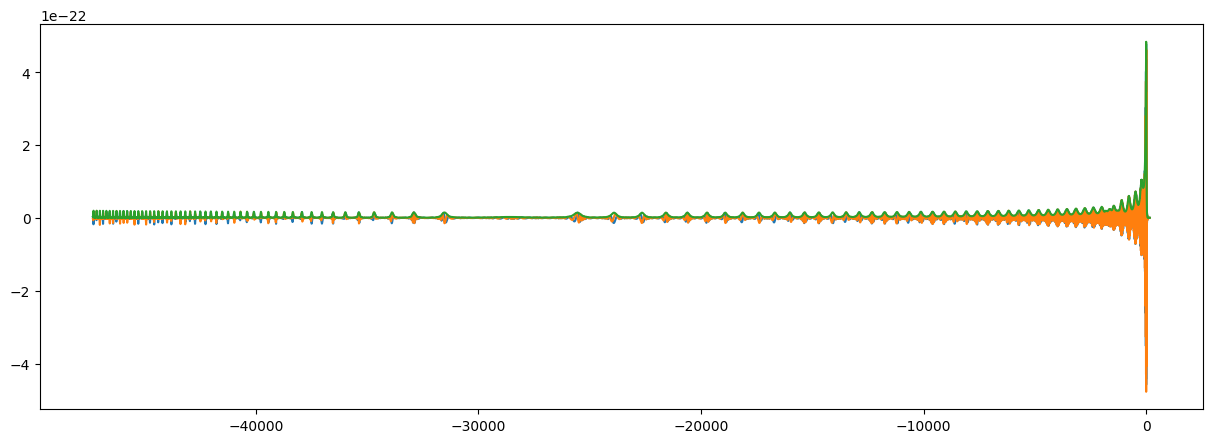

In [1720]:
plt.figure(figsize=(15,5))
plt.plot(testd[:,0],testd[:,1]*G_SI*M_SI/D_SI/C_SI/C_SI)
plt.plot(testd[:,0],testd[:,2]*G_SI*M_SI/D_SI/C_SI/C_SI)
plt.plot(testd[:,0],np.abs(testd[:,1]*G_SI*M_SI/D_SI/C_SI/C_SI +1j*testd[:,2]*G_SI*M_SI/D_SI/C_SI/C_SI))
#plt.xlim(xmin=-1000)

In [1721]:
hf.close()